In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os
import os.path
import sys
import tensorflow as tf
import math
from data_loader import DataLoader
from my_constants import Constants
from emotion_classifier import EmotionClassifier
import numpy as np
import scipy
import pandas as pd

np.random.seed(666)

# Logistics

In [2]:
model_name = 'FC'
batch_size = 90
seed = 666
filename = '/mas/u/asma_gh/uncnet/datasets/FER+/all.csv'
max_nrof_epochs=100000
hidden_layer_size=[128, 128]
keep_probability=0.8
weight_decay=0.0
n_epistemic = 100
n_aleatoric = 100

logs_base_dir = '/mas/u/asma_gh/uncnet/epoch_logs_model'
embedding_model = 'CASIA_WebFace_Inception_ResNet_v1'
embedding_layer = 'Mixed_7a'
learning_rate = 0.0001

# Load data

In [3]:
data_loader = DataLoader(filename, import_embedding=True, embedding_model=embedding_model,
                                      embedding_layer=embedding_layer, seed=seed)

Converting row 0 of dataframe to numpy array.
Converting row 100 of dataframe to numpy array.
Converting row 200 of dataframe to numpy array.
Converting row 300 of dataframe to numpy array.
Converting row 400 of dataframe to numpy array.
Converting row 500 of dataframe to numpy array.
Converting row 600 of dataframe to numpy array.
Converting row 700 of dataframe to numpy array.
Converting row 800 of dataframe to numpy array.
Converting row 900 of dataframe to numpy array.
Converting row 1000 of dataframe to numpy array.
Converting row 1100 of dataframe to numpy array.
Converting row 1200 of dataframe to numpy array.
Converting row 1300 of dataframe to numpy array.
Converting row 1400 of dataframe to numpy array.
Converting row 1500 of dataframe to numpy array.
Converting row 1600 of dataframe to numpy array.
Converting row 1700 of dataframe to numpy array.
Converting row 1800 of dataframe to numpy array.
Converting row 1900 of dataframe to numpy array.
Converting row 2000 of dataframe

Converting row 14600 of dataframe to numpy array.
Converting row 14700 of dataframe to numpy array.
Converting row 14800 of dataframe to numpy array.
Converting row 14900 of dataframe to numpy array.
Converting row 15000 of dataframe to numpy array.
Converting row 15100 of dataframe to numpy array.
Converting row 15200 of dataframe to numpy array.
Converting row 15300 of dataframe to numpy array.
Converting row 15400 of dataframe to numpy array.
Converting row 15500 of dataframe to numpy array.
Converting row 15600 of dataframe to numpy array.
Converting row 15700 of dataframe to numpy array.
Converting row 15800 of dataframe to numpy array.
Converting row 15900 of dataframe to numpy array.
Converting row 16000 of dataframe to numpy array.
Converting row 16100 of dataframe to numpy array.
Converting row 16200 of dataframe to numpy array.
Converting row 16300 of dataframe to numpy array.
Converting row 16400 of dataframe to numpy array.
Converting row 16500 of dataframe to numpy array.


Converting row 29000 of dataframe to numpy array.
Converting row 29100 of dataframe to numpy array.
Converting row 29200 of dataframe to numpy array.
Converting row 29300 of dataframe to numpy array.
Converting row 29400 of dataframe to numpy array.
Converting row 29500 of dataframe to numpy array.
Converting row 29600 of dataframe to numpy array.
Converting row 29700 of dataframe to numpy array.
Converting row 29800 of dataframe to numpy array.
Converting row 29900 of dataframe to numpy array.
Converting row 30000 of dataframe to numpy array.
Converting row 30100 of dataframe to numpy array.
Converting row 30200 of dataframe to numpy array.
Converting row 30300 of dataframe to numpy array.
Converting row 30400 of dataframe to numpy array.
Converting row 30500 of dataframe to numpy array.
Converting row 30600 of dataframe to numpy array.
Converting row 30700 of dataframe to numpy array.
Converting row 30800 of dataframe to numpy array.
Converting row 30900 of dataframe to numpy array.


In [4]:
test_labels, test_embeddings = data_loader.get_test_batch()
valid_labels, valid_embeddings = data_loader.get_valid_batch()

In [5]:
def load_model_dir(best_checkpoints, uncertainty_type):
    epoch_num = best_checkpoints[uncertainty_type]
    model_filename = f'{model_name}_{epoch_num}.ckpt-{epoch_num}'
    root_dir = f'{logs_base_dir}/{embedding_model}/{embedding_layer}/{str(learning_rate)}/{uncertainty_type}'
    
    model_dir = None
    for sub_dir in os.listdir(root_dir):
        if sub_dir.startswith('.'):
            continue
        model_dir = os.path.join(os.path.join(root_dir, sub_dir), model_filename)
    if not model_dir:
        print ('Error! Did not find model.')
        return None
    return model_dir

# Load model and conduct inference

In [31]:
def get_performance_on_data(best_checkpoints, uncertainty_type, x, y):
    
    if uncertainty_type == 'both':
        model_dir = load_model_dir(best_checkpoints, uncertainty_type='epistemic')
    elif uncertainty_type == 'none':
        model_dir = load_model_dir(best_checkpoints, uncertainty_type)
        
    tf.reset_default_graph()
    with tf.Session() as sess:    
        saver = tf.train.import_meta_graph(f'{model_dir}.meta')
        saver.restore(sess, model_dir)

        tf_loss = tf.get_default_graph().get_tensor_by_name("loss:0")
        tf_acc = tf.get_default_graph().get_tensor_by_name("acc:0")
        tf_x = tf.get_default_graph().get_tensor_by_name("x:0")
        tf_y = tf.get_default_graph().get_tensor_by_name("y:0")
        tf_dropout_prob = tf.get_default_graph().get_tensor_by_name("dropout_prob:0")
        tf_logits = tf.get_default_graph().get_tensor_by_name("logits:0")
        
        def mc_sampling():
            # T x N x C
            mc_logits = []
            # T x N x C
            mc_class_probabilities = []
            # T
            mc_losses = []
            # T x N
            mc_entropies = []
            for i in range(n_epistemic):
                loss, logits = sess.run([tf_loss, tf_logits], feed_dict={
                    tf_x: x, tf_y: y, tf_dropout_prob: keep_probability})
                mc_logits.append(logits)
                class_probability = scipy.special.softmax(logits)
                mc_class_probabilities.append(class_probability)
                mc_entropy = [scipy.stats.entropy(p_t) for p_t in class_probability]
                mc_entropies.append(mc_entropy)
                mc_losses.append(loss)
            mean_logits = np.mean(mc_logits, axis=0)
            mean_class_probabilities = np.mean(mc_class_probabilities, axis=0)
            score = calc_acc(mean_class_probabilities, y)
            total_u = [scipy.stats.entropy(p_t) for p_t in mean_class_probabilities]
            aleatoric_u = np.mean(mc_entropies, axis=0)
            epistemic_u = total_u - aleatoric_u
            return np.mean(mc_losses), score, mean_class_probabilities, total_u, aleatoric_u, epistemic_u

        def calc_acc(class_probabilities, y):
            predictions = np.argmax(class_probabilities, axis=1)
            target = np.argmax(y, axis=1)
            acc = np.mean(np.equal(target, predictions))
            return acc

        """Returns the model's performance on input data X and targets Y."""
        if uncertainty_type == 'none':
            loss, score, logits = sess.run([tf_loss, tf_acc, tf_logits], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
            class_probabilities = scipy.special.softmax(logits)
            return loss, score, class_probabilities, None, None, None
        
        elif uncertainty_type == 'both':
            return mc_sampling()

# Preparing for answering research questions
Loading best checkpoints per uncertainty type

In [32]:
# BEST_CHECKPOINTS = {'none': 1068, 'aleatoric':1012 ,'epistemic': 319 , 'both':53} # TODO only none is done
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':353 ,'epistemic': 406 , 'both':192}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':428 ,'epistemic': 406 , 'both':192}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':428 ,'epistemic': 474 , 'both':530}
BEST_CHECKPOINTS = {'none': 403, 'aleatoric':4194 ,'epistemic': 474 , 'both':4079}

# using logits (_u) or probabilities (_p_u) uncertainties?
unc_postfix = '_u' #'_p_u' is legacy

# Q1: Does modeling uncertainty improve accuracy?

Observation: The results are very similar on the hold-out test set. Modeling uncertainties is a bit lower, but not significant. Baseline acc: 0.54912, UncNet acc: 0.53792

#### Sanity check
Do the validation results map the tensorboard?

In [33]:
unc_types = ['none', 'both']
# Get validation results
print ('Validation set:')
for unc in unc_types:
    print (f'\nModeling {unc} uncertainties...')
    loss, score, class_probabilities, total_u, aleatoric_u, epistemic_u = get_performance_on_data(
        BEST_CHECKPOINTS, unc, valid_embeddings, valid_labels)
    print(f'loss: {loss:.5f}, score: {score:.5f}, class_probabilities: {class_probabilities}, total uncertainty: {total_u}, aleatoric uncertainty: {aleatoric_u}, epistemic uncertainty: {epistemic_u}')

Validation set:

Modeling none uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.53035, score: 0.54912, class_probabilities: [[7.52242340e-05 5.05997741e-05 4.50981406e-06 ... 2.41598150e-06
  6.17416890e-06 1.34404690e-05]
 [1.33297144e-04 2.23066090e-05 7.51328571e-06 ... 2.63488732e-06
  6.34247363e-06 1.87490587e-05]
 [8.59581924e-05 2.04799853e-05 1.42504523e-05 ... 5.19467130e-06
  6.89494664e-06 1.27197445e-05]
 ...
 [8.98211656e-05 3.13638411e-05 1.53292804e-05 ... 5.44161230e-06
  4.79664004e-06 1.43247253e-05]
 [8.03823714e-05 1.06870342e-04 4.26609404e-06 ... 2.48557058e-06
  6.13682778e-06 1.06085654e-05]
 [1.81950061e-04 1.05208401e-05 2.43325085e-05 ... 5.04297441e-06
  8.15697877e-06 1.31060397e-05]], total uncertainty: None, aleatoric uncertainty: None, epistemic uncertainty: None

Modeling both uncertainties...
INFO:tensorfl

#### How about the unseen test set?

In [35]:
unc_types = ['none', 'both']
# Get Test results
print ('Test set:')
for unc in unc_types:
    print (f'\nModeling {unc} uncertainties...')
    loss, score, class_probabilities, total_u, aleatoric_u, epistemic_u = get_performance_on_data(
        BEST_CHECKPOINTS, unc, test_embeddings, test_labels)
    print(f'loss: {loss:.5f}, score: {score:.5f}, class_probabilities: {class_probabilities}, total uncertainty: {total_u}, aleatoric uncertainty: {aleatoric_u}, epistemic uncertainty: {epistemic_u}')

Test set:

Modeling none uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.49306, score: 0.54848, class_probabilities: [[1.7727854e-05 2.4000843e-05 8.3355022e-05 ... 2.2432090e-05
  1.1121705e-06 1.2244247e-05]
 [9.0794099e-05 4.8929414e-05 2.0772623e-05 ... 7.8570538e-06
  5.7871989e-06 1.1269532e-05]
 [4.3678217e-05 6.7484929e-05 1.5903335e-05 ... 7.1318714e-06
  3.7548969e-06 1.0057637e-05]
 ...
 [2.1979415e-04 2.1301787e-05 6.5404861e-06 ... 1.8350989e-06
  6.8818085e-06 1.8308609e-05]
 [1.4596777e-04 1.2139464e-05 2.6058196e-06 ... 1.4789458e-06
  1.0132847e-05 1.8165627e-05]
 [1.6348550e-04 2.3419701e-05 1.0881040e-05 ... 3.4450266e-06
  6.5100621e-06 1.3718727e-05]], total uncertainty: None, aleatoric uncertainty: None, epistemic uncertainty: None

Modeling both uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_g

# Q2: Does excluding the points with high uncertainty, improve accuracy?

Observation: 

Sorting by aleatoric, epistemic, or total uncertainties improves both baseline and UncNet similarly.
All samples:
Baseline: , Uncnet:
top 75% confident samples:
aleatoric - Baseline: 0.60283, Uncnet: 0.59799
epistemic - Baseline: 0.58159, Uncnet: 0.56781
total - Baseline: 0.60246, Uncnet: 0.59836


In [38]:
dataset = pd.read_csv(filename)

train = dataset[dataset['dataset'] == 'Training'].reset_index(drop=True)
train['original_ind'] = train.index

test = dataset[dataset['dataset'] == 'PublicTest'].reset_index(drop=True)
test['original_ind'] = test.index

In [39]:
loss, score, class_probabilities, total_u, aleatoric_u, epistemic_u = get_performance_on_data(
        BEST_CHECKPOINTS, 'both', test_embeddings, test_labels)

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/epistemic/2019_04_22_10_36_21/FC_474.ckpt-474


In [40]:
test['aleatoric_u'] = aleatoric_u
test['epistemic_u'] = epistemic_u
test['total_u'] = total_u

In [43]:
def find_unc_samples(test, uncertainty_type, percentage=0.75, sort_ascending=True):
    '''
    Find samples that are in the [percentage] quantile with 
    highest or lowest uncertainty values based on [sort_ascending]
    '''
    test = test.sort_values(by=f'{uncertainty_type}{unc_postfix}', ascending=sort_ascending)
    max_ind = int(percentage*len(test))
    sub_index = test.index[0:max_ind]
    return sub_index

for unc in ['aleatoric', 'epistemic', 'total']:
    print (f'Sorting based on uncertainty type: {unc}...')
    sub_indices = find_unc_samples(test, unc)
    sub_test_embeddings = test_embeddings[sub_indices]
    sub_test_labels = test_labels[sub_indices]
    for unc_type in ['none', 'both']:
        print(f'New performance metrics for {unc_type}:')
        loss, score, class_probabilities, total_u, aleatoric_u, epistemic_u = get_performance_on_data(BEST_CHECKPOINTS, unc_type, sub_test_embeddings, sub_test_labels)
        print(f'loss: {loss:.5f}, score: {score:.5f}, class_probabilities: {class_probabilities}, total uncertainty: {total_u}, aleatoric uncertainty: {aleatoric_u}, epistemic uncertainty: {epistemic_u}')
        

Sorting based on uncertainty type: aleatoric...
New performance metrics for none:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.38834, score: 0.60283, class_probabilities: [[1.98605248e-05 3.85296321e-03 6.57738474e-06 ... 1.86540058e-06
  8.06132846e-07 5.18487150e-06]
 [8.91208492e-06 3.72410612e-03 4.27453642e-06 ... 1.28467559e-06
  3.80665284e-07 4.97971769e-06]
 [1.11749341e-05 2.24225619e-03 6.64139998e-06 ... 2.18792593e-06
  5.37408027e-07 5.77925721e-06]
 ...
 [1.18679105e-04 6.33489617e-05 2.90989083e-05 ... 9.58993678e-06
  7.74303498e-06 1.28296579e-05]
 [1.00590813e-04 2.45940591e-05 6.44516149e-06 ... 2.62096046e-06
  4.29555348e-06 2.23191855e-05]
 [1.18369171e-04 5.86016249e-05 2.15436376e-05 ... 8.41948986e-06
  7.91308321e-06 1.32917521e-05]], total uncertainty: None, aleatoric uncertainty: None, epistemic uncertainty: None
New perform

New performance metrics for none:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.44807, score: 0.58159, class_probabilities: [[2.27484761e-05 1.54882637e-05 1.01093925e-03 ... 1.26631552e-04
  1.01533885e-06 1.29747268e-05]
 [2.59610242e-05 1.76347094e-05 1.01285579e-03 ... 1.23830687e-04
  1.21693290e-06 1.25548177e-05]
 [2.14992851e-05 1.69084087e-05 1.00881571e-03 ... 1.23075180e-04
  9.46653472e-07 1.28247284e-05]
 ...
 [1.52731373e-04 1.45818685e-05 1.50049062e-04 ... 2.20694055e-05
  6.00728754e-06 1.58108614e-05]
 [6.50551592e-05 6.75413976e-05 3.09379830e-05 ... 1.17428581e-05
  6.63439187e-06 1.26691884e-05]
 [1.33949987e-04 8.65996626e-05 1.07172909e-05 ... 4.66023175e-06
  7.85425163e-06 1.31385523e-05]], total uncertainty: None, aleatoric uncertainty: None, epistemic uncertainty: None
New performance metrics for both:
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.38935, score: 0.60246, class_probabilities: [[1.9853593e-05 3.8516186e-03 6.5750896e-06 ... 1.8647496e-06
  8.0585153e-07 5.1830621e-06]
 [8.9089754e-06 3.7228065e-03 4.2730444e-06 ... 1.2842272e-06
  3.8053244e-07 4.9779796e-06]
 [1.1171034e-05 2.2414736e-03 6.6390821e-06 ... 2.1871624e-06
  5.3722050e-07 5.7772399e-06]
 ...
 [1.1972861e-04 3.2970711e-05 2.7193249e-05 ... 8.9263667e-06
  7.4186678e-06 1.5037101e-05]
 [1.0923060e-04 2.3917602e-05 6.7750996e-05 ... 1.6666314e-05
  7.3087385e-06 1.5184870e-05]
 [1.3484333e-04 1.8538969e-05 4.7505448e-05 ... 1.1139873e-05
  7.4284167e-06 1.5362033e-05]], total uncertainty: None, aleatoric uncertainty: None, epistemic uncertainty: None
New performance metrics for both:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_

# Q3: Is there a relationship between inter-rater agreement and uncertainty?

Observation:

There is a significant positive correlation between aleatoric/epistemic/total uncertainty and disagreement_p/entropy.
Aleatoric has a higher r value than espistemic.

<Figure size 360x360 with 0 Axes>

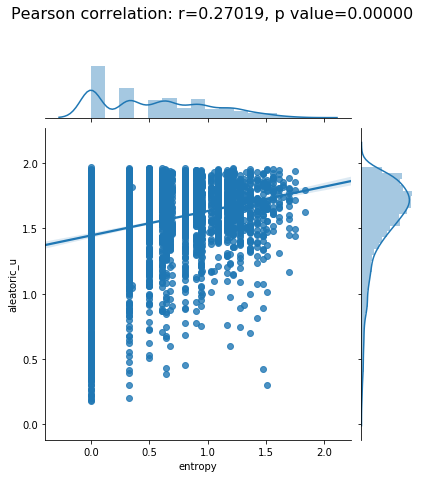

<Figure size 360x360 with 0 Axes>

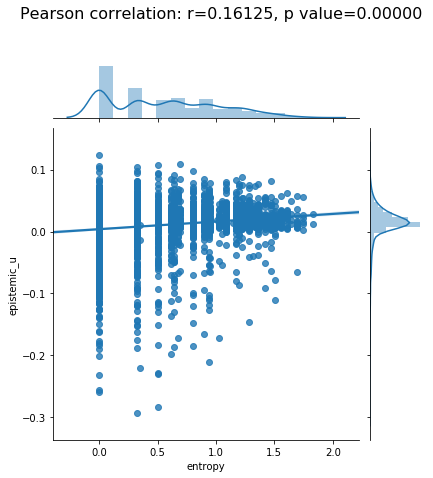

<Figure size 360x360 with 0 Axes>

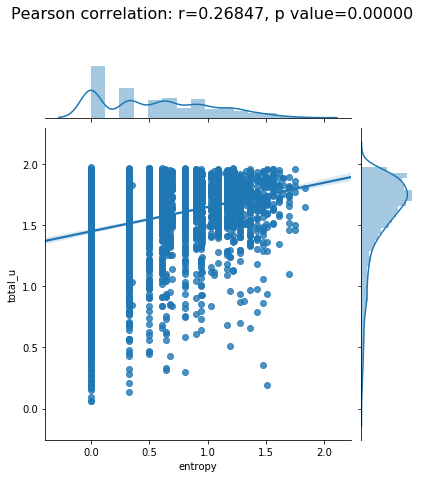

<Figure size 360x360 with 0 Axes>

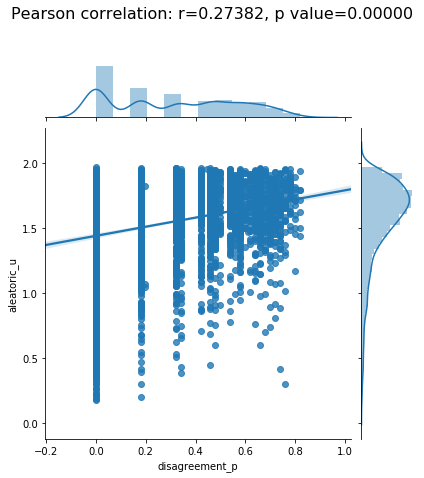

<Figure size 360x360 with 0 Axes>

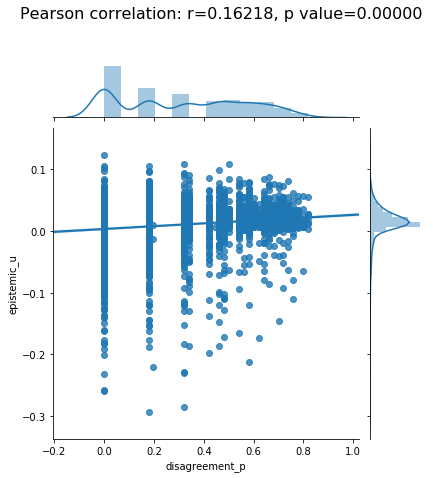

<Figure size 360x360 with 0 Axes>

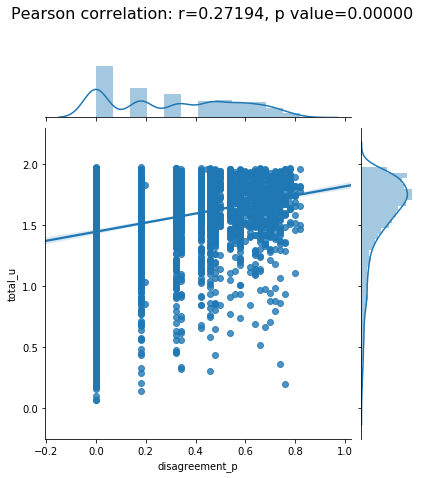

In [50]:
def comparison_plots(test, x, y):
    plt.figure(figsize=(5,5))
    g = sns.jointplot(test[x], test[y], kind="reg")
    r, p = scipy.stats.pearsonr(test[x], test[y])
    plt.suptitle(f'Pearson correlation: r={r:.5f}, p value={p:.5f}', size=16, y=1.1)
    plt.ylabel(y)
    plt.xlabel(x)
    
for x in ['entropy', 'disagreement_p']:
    comparison_plots(test, x, f'aleatoric{unc_postfix}')
    comparison_plots(test, x, f'epistemic{unc_postfix}')
    comparison_plots(test, x, f'total{unc_postfix}')


# Q4: What do samples with high/low aleatoric/epistemic uncertainty look like?

Observations:

Samples with low aleatoric uncertainty have higher inter-annotator agreement, i.e. less spread in the annotations distribution. Inversely, high aleatoric uncertainty -> lower agreement

It is hard to explain what low epistemic uncertainty explains.

Uncertainty type: aleatoric
Uncertainty type: epistemic
Uncertainty type: total


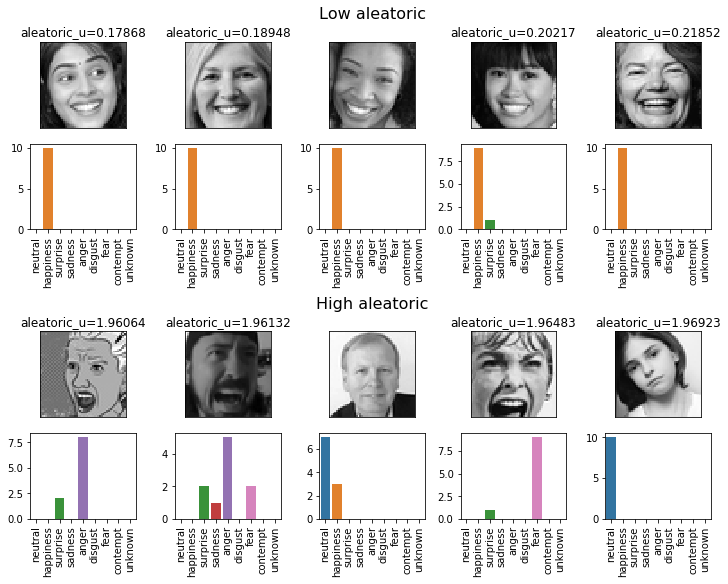

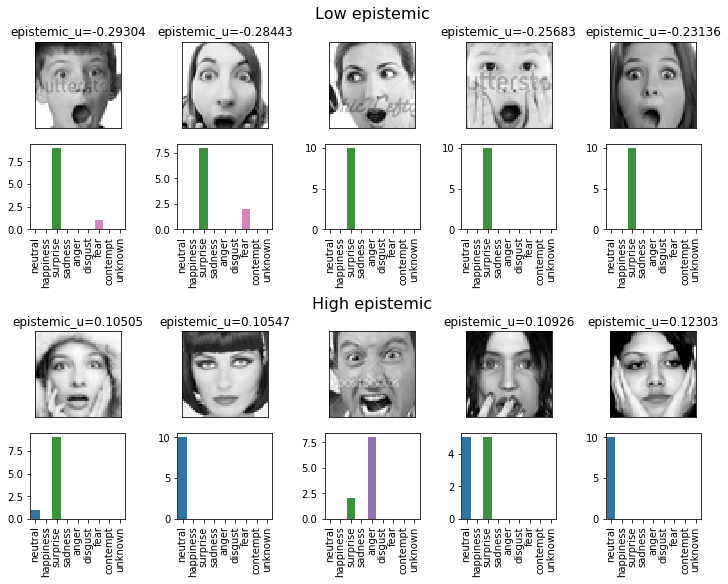

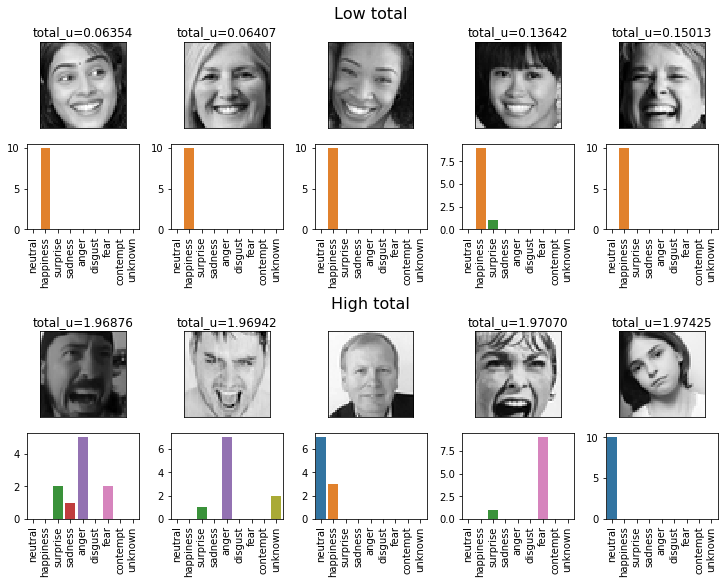

In [46]:
EMOTION_COLS = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt' ,'unknown']
def _plot_img_hist(inp, axes, ax_i, ax_j, ttl_col):
    img_ax = axes[ax_i, ax_j]
    hist_ax = axes[ax_i+1, ax_j]
    
    NEW_SHAPE = (48, 48)
    img_arr = np.array([int(i) for i in inp['pixels'].split(' ')])
    img_arr = np.reshape(img_arr, NEW_SHAPE)
    img_ax.set_title(f'{ttl_col}={inp[ttl_col]:.5f}')
    img_ax.imshow(img_arr, cmap='gray')
    img_ax.set_xticks([])
    img_ax.set_yticks([])
    
    sns.barplot(np.arange(len(EMOTION_COLS)), list(inp[EMOTION_COLS]), ax=hist_ax)
    hist_ax.set_xticklabels(EMOTION_COLS, rotation='vertical')


# Show n images with highest disagreement and n images with lowest disagreement probability
def show_extreme_cases(inp, n, ttl_col):
    f, axes = plt.subplots(4, n, figsize=(n*2, 8), constrained_layout=True)
    for i in range(n):
        _plot_img_hist(inp.iloc[i], axes, 0, i, f'{ttl_col}{unc_postfix}')
    axes[0, int(n/2)].set_title(f'Low {ttl_col}', size=16, y=1.2)
    
    for i in range(n):
        _plot_img_hist(inp.iloc[len(inp)-1-i], axes, 2, n-i-1, f'{ttl_col}{unc_postfix}')
    axes[2, int(n/2)].set_title(f'High {ttl_col}', size=16, y=1.2)

for unc in ['aleatoric', 'epistemic', 'total']:
    print (f'Uncertainty type: {unc}')
    sorted_test = test.sort_values(by=f'{unc}{unc_postfix}')
    show_extreme_cases(sorted_test, 5, unc)
    

# Q5: Maybe doesn't influence accuracy, but are the softmax outputs better caliberated?

Note that because of the way we formed the problem and used aggregate user ratings, traditional caliberation metrics such as Expected Calibration Error (ECE), Maximum Calibration Error (MCE), and reliability diagram may not be relevant. Here, we use distribution distance metrics between predicted and input probabilities.

Observations:

jensen shannon distance of probabilites in uncnet codition is slightly higher :|

But, the cosine similarity of probabilities with uncnet is higher, as we expect, though the differences are small.

In [47]:
_, _, baseline_class_probabilities, _, _, _= get_performance_on_data(
    BEST_CHECKPOINTS, 'none', test_embeddings, test_labels)

_, _, uncnet_class_probabilities, _, _, _ = get_performance_on_data(
    BEST_CHECKPOINTS, 'both', test_embeddings, test_labels)

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/epistemic/2019_04_22_10_36_21/FC_474.ckpt-474


In [48]:
def print_distance_metrics(pred, true, ttl):
    print ('\n'+ttl)
    js_s = []
    s_sim_s =[]
    for i in range(len(pred)):
        js_s.append(scipy.spatial.distance.jensenshannon(pred[i], true[i]))
        s_sim_s.append(scipy.spatial.distance.cosine(pred[i], true[i]))
    print (f'Jensen shannon distance: mean={np.mean(js_s):.3f}, std={np.std(js_s):.3f}')
    print (f'Cosine similiraty: mean={np.mean(s_sim_s):.3f}, std={np.std(s_sim_s):.3f}')
#     return np.mean(js_s), np.std(js_s), np.mean(s_sim_s), np.std(s_sim_s)

print_distance_metrics(baseline_class_probabilities, test_labels, 'Baseline')
print_distance_metrics(uncnet_class_probabilities, test_labels, 'UncNet')


Baseline
Jensen shannon distance: mean=0.473, std=0.131
Cosine similiraty: mean=0.308, std=0.264

UncNet
Jensen shannon distance: mean=0.480, std=0.133
Cosine similiraty: mean=0.318, std=0.263


### More examples

Uncertainty type: aleatoric
Uncertainty type: epistemic
Uncertainty type: total


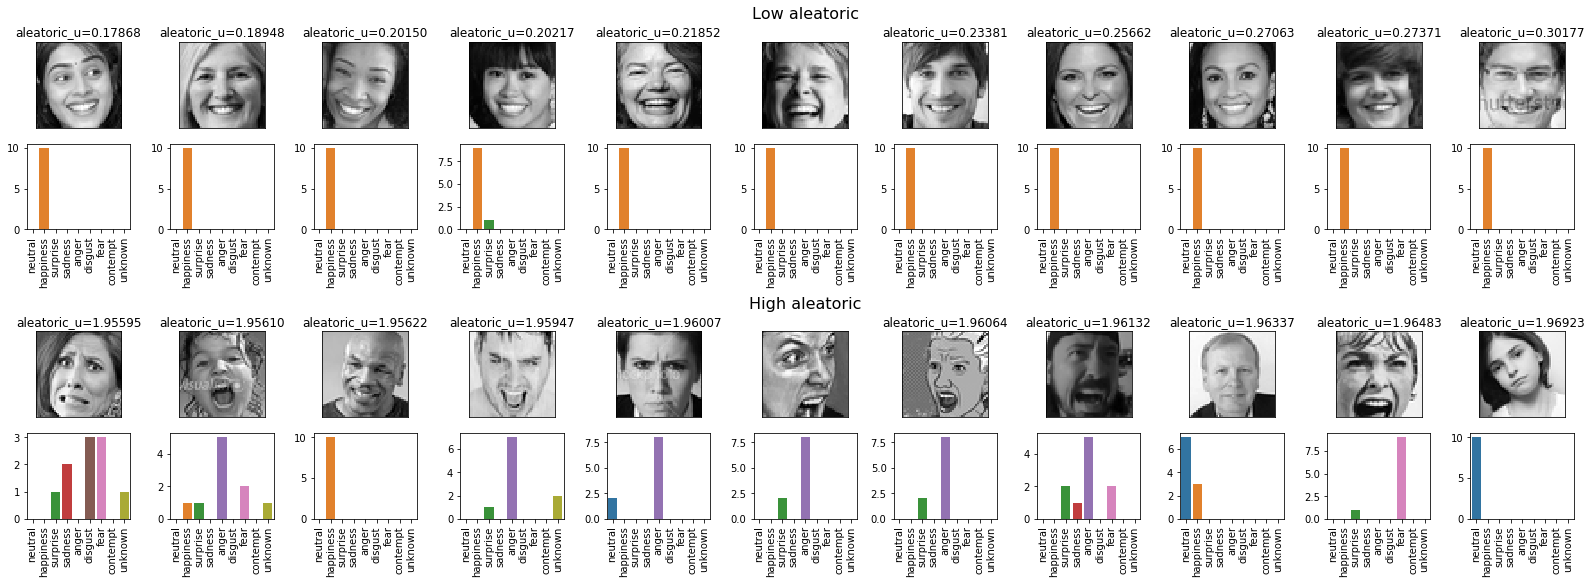

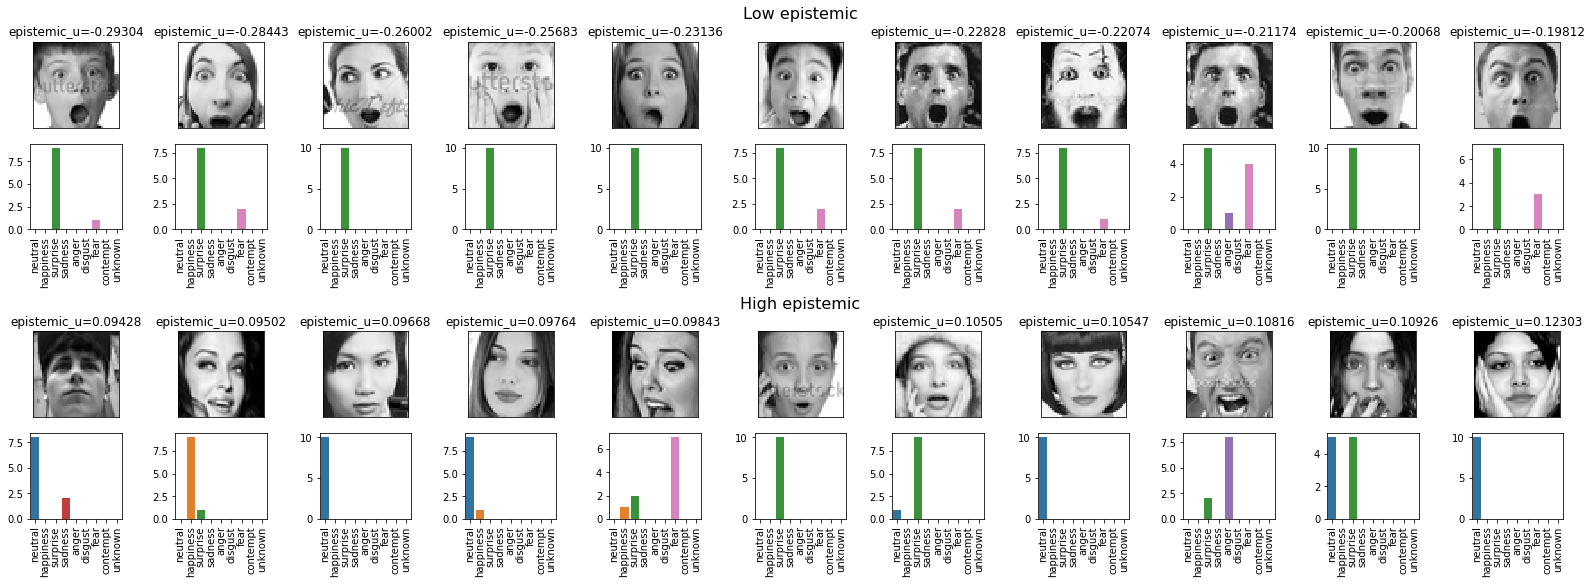

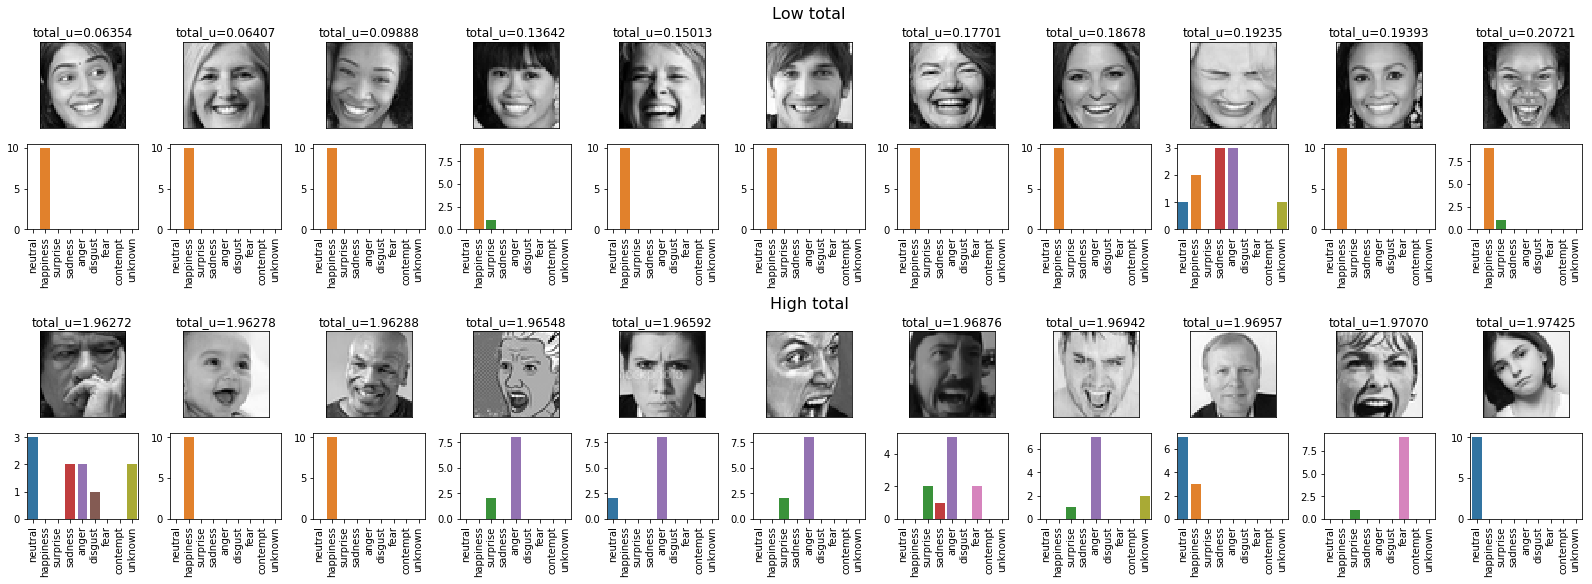

In [49]:
for unc in ['aleatoric', 'epistemic', 'total']:
    print (f'Uncertainty type: {unc}')
    sorted_test = test.sort_values(by=f'{unc}{unc_postfix}')
    show_extreme_cases(sorted_test, 11, unc)

# Post-hoc analyses. Are certain classes more frequent in training data? 

E.g. Surprise is more common that other classes?

In [71]:
def post_process(series):
    idx = np.argmax(list(series[EMOTION_COLS]))
    series['target'] = EMOTION_COLS[idx]
    return series

post_processed_test = test.apply(post_process, axis=1)
post_processed_train = train.apply(post_process, axis=1)

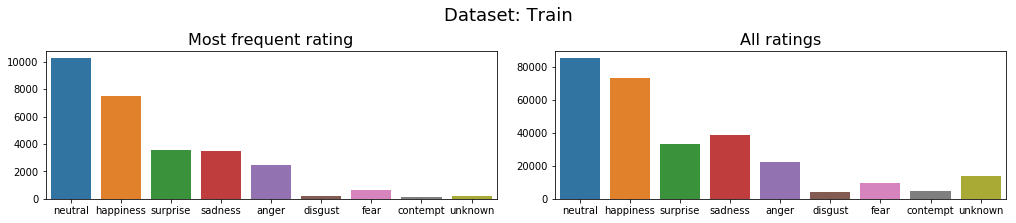

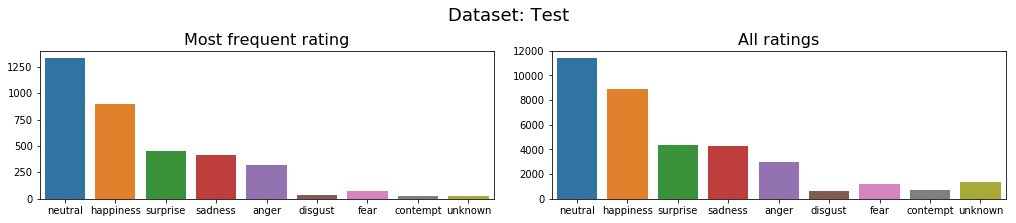

In [91]:
def plot_dataset_stats(subset, ttl):
    W = 7; H=3
    f, axes = plt.subplots(1, 2, figsize=(W*2, H), constrained_layout=True)
    plt.suptitle(f'Dataset: {ttl}', fontsize=18)
    most_frequent_vals = []
    for emotion in EMOTION_COLS:
        val = np.sum(subset['target']==emotion)
        most_frequent_vals.append(val)
    sns.barplot(x=EMOTION_COLS, y=most_frequent_vals, ax=axes[0])
    axes[0].set_title('Most frequent rating', fontsize=16)

    all_vals = []
    for emotion in EMOTION_COLS:
        val = np.sum(subset[emotion])
        all_vals.append(val)
    sns.barplot(x=EMOTION_COLS, y=all_vals, ax=axes[1])
    axes[1].set_title('All ratings', fontsize=16)
        
plot_dataset_stats(post_processed_train, 'Train')
plot_dataset_stats(post_processed_test, 'Test')

In [77]:
def print_dataset_stats(subset, ttl):
    print (f'\n\n{ttl}\n')
    print ('# of most frequent ratings of emotions...')
    most_frequent_vals=[]
    for emotion in EMOTION_COLS:
        val = np.sum(subset['target']==emotion)
        print (f'{emotion}: {val}')

    print ('\n# of total ratings of emotions...')
    for emotion in EMOTION_COLS:
        val = np.sum(subset[emotion])
        print (f'{emotion}: {val}')
        
print_dataset_stats(post_processed_train, 'Train')
print_dataset_stats(post_processed_test, 'Test')



Train

# of most frequent ratings of emotions...
neutral: 10309
happiness: 7528
surprise: 3562
sadness: 3515
anger: 2467
disgust: 191
fear: 652
contempt: 165
unknown: 170

# of total ratings of emotions...
neutral: 85563
happiness: 73454
surprise: 33074
sadness: 38538
anger: 22522
disgust: 4247
fear: 9641
contempt: 4845
unknown: 13591


Test

# of most frequent ratings of emotions...
neutral: 1335
happiness: 899
surprise: 456
sadness: 412
anger: 319
disgust: 34
fear: 74
contempt: 24
unknown: 26

# of total ratings of emotions...
neutral: 11430
happiness: 8900
surprise: 4337
sadness: 4265
anger: 3007
disgust: 616
fear: 1164
contempt: 677
unknown: 1381


# Debugging only

In [ ]:
# legacy
# WHAT??? {unc}_u and {unc}_p_u should have roughly the same ranking order. What's happening here?
# test[['aleatoric_u', 'aleatoric_p_u', 'epistemic_u', 'epistemic_p_u']]

# Legacy

In [6]:
# legacy
# def get_performance_on_data(best_checkpoints, uncertainty_type, x, y):
#     model_dir = load_model_dir(best_checkpoints, uncertainty_type)
#     tf.reset_default_graph()
#     with tf.Session() as sess:    
#         saver = tf.train.import_meta_graph(f'{model_dir}.meta')
#         saver.restore(sess, model_dir)
        
#         tf_loss = tf.get_default_graph().get_tensor_by_name("loss:0")
#         tf_acc = tf.get_default_graph().get_tensor_by_name("acc:0")
#         tf_x = tf.get_default_graph().get_tensor_by_name("x:0")
#         tf_y = tf.get_default_graph().get_tensor_by_name("y:0")
#         tf_dropout_prob = tf.get_default_graph().get_tensor_by_name("dropout_prob:0")
        
#         tf_logits = tf.get_default_graph().get_tensor_by_name("logits:0")
#         if uncertainty_type == 'aleatoric' or uncertainty_type == 'both':
#             tf_logits_mean = tf.get_default_graph().get_tensor_by_name("logits_mean:0")
#             tf_logits_var = tf.get_default_graph().get_tensor_by_name("logits_var:0")

#         aleatoric_u = None
#         aleatoric_p_u = None
        
#         epistemic_u = None
#         epistemic_p_u = None
        
#         def mc_aleatoric_sampling(mean_logits, aleatoric_u):
#             mc_logits = []
#             mc_class_probabilities = []
#             for i in range(n_aleatoric):
#                 sampled_noise = np.random.normal(loc=np.zeros_like(mean_logits), scale=np.transpose([np.sqrt(aleatoric_u)]*9)) # num_classes
#                 distorted_logits = mean_logits + sampled_noise
#                 mc_logits.append(distorted_logits)
#                 mc_class_probabilities.append(scipy.special.softmax(distorted_logits))
#             aleatoric_p_u = np.mean(np.var(mc_class_probabilities, axis=(0)), axis=(1))
# #             aleatoric_p_u = np.var(mc_class_probabilities, axis=(0,2))
#             return mc_class_probabilities, aleatoric_p_u

#         def mc_epistemic_sampling():
#             mc_logits = []
#             mc_class_probabilities = []
#             mc_losses = []
#             for i in range(n_epistemic):
#                 loss, logits = sess.run([tf_loss, tf_logits], feed_dict={
#                     tf_x: x, tf_y: y, tf_dropout_prob: keep_probability})
#                 mc_logits.append(logits)
#                 mc_class_probabilities.append(scipy.special.softmax(logits))
#                 mc_losses.append(loss)
#             mean_logits = np.mean(mc_logits, axis=0)
#             score = calc_acc(mean_logits, y)
#             epistemic_u = np.var(mc_logits, axis=(0,2))
#             epistemic_p_u = np.mean(np.var(mc_class_probabilities, axis=(0)), axis=(1))
# #             epistemic_p_u = np.var(mc_class_probabilities, axis=(0,2))
#             return mc_logits, mc_class_probabilities, np.mean(mc_losses), score, epistemic_u, epistemic_p_u

#         def mc_epistemic_aleatoric_sampling():
#             mc_logits_mean = []
#             mc_logits_var = []
#             mc_epistemic_class_probabilities = []
#             mc_both_class_probabilities = []
#             mc_losses = []
#             for i in range(n_epistemic):
#                 loss, logits_mean, logits_var = sess.run([tf_loss, tf_logits_mean, tf_logits_var], feed_dict={
#                     tf_x: x, tf_y: y, tf_dropout_prob: keep_probability})
#                 mc_logits_mean.append(logits_mean)
#                 mc_logits_var.append(logits_var)
#                 mc_epistemic_class_probabilities.append(scipy.special.softmax(logits_mean))
#                 mc_aleatoric_class_probabilities, sub_aleatoric_p_u  = mc_aleatoric_sampling(logits_mean, logits_var)
#                 mc_both_class_probabilities.extend(mc_aleatoric_class_probabilities)
#                 mc_losses.append(loss)
#             mean_logits = np.mean(mc_logits, axis=0)
#             score = calc_acc(mean_logits, y)
#             epistemic_u = np.var(mc_logits, axis=(0,2))
#             epistemic_p_u = np.mean(np.var(mc_class_probabilities, axis=(0)), axis=(1))
# #             epistemic_p_u = np.var(mc_class_probabilities, axis=(0,2))
#             return mc_logits, mc_class_probabilities, np.mean(mc_losses), score, epistemic_u, epistemic_p_u

#         def calc_acc(logits, y):
#             class_probabilities = scipy.special.softmax(logits)
#             predictions = np.argmax(class_probabilities, axis=1)
#             target = np.argmax(y, axis=1)
#             acc = np.mean(np.equal(target, predictions))
#             return acc

#         """Returns the model's performance on input data X and targets Y."""
#         if uncertainty_type == 'none':
#             loss, score, logits = sess.run([tf_loss, tf_acc, tf_logits], feed_dict={
#                 tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
#             class_probabilities = scipy.special.softmax(logits)
#         elif uncertainty_type == 'aleatoric':
#             loss, score, logits, aleatoric_u = sess.run([tf_loss, tf_acc, tf_logits_mean, tf_logits_var], feed_dict={
#                 tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
#             aleatoric_p_u = mc_aleatoric_sampling(logits, aleatoric_u)
#             class_probabilities = scipy.special.softmax(logits)
#         elif uncertainty_type == 'epistemic':
#             mc_logits, mc_class_probabilities, loss, score, epistemic_u, epistemic_p_u = mc_epistemic_sampling()
#             class_probabilities = np.mean(mc_class_probabilities, axis=0)
#         elif uncertainty_type == 'both':
#             logits, aleatoric_u = sess.run([tf_logits_mean, tf_logits_var], feed_dict={
#                 tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
#             aleatoric_p_u = mc_aleatoric_sampling(logits, aleatoric_u)
#             mc_logits, mc_class_probabilities, loss, score, epistemic_u, epistemic_p_u = mc_epistemic_sampling()
#             class_probabilities = np.mean(mc_class_probabilities, axis=0)

#         return loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u

In [34]:
# legacy
# unc_types = ['none', 'aleatoric', 'epistemic', 'both']
# # Get validation results
# print ('Validation set:')
# for unc in unc_types:
#     print (f'\nModeling {unc} uncertainties...')
#     loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u = get_performance_on_data(BEST_CHECKPOINTS, unc,
#                                                                     valid_embeddings, valid_labels)
#     print(f'loss: {loss:.5f}, score: {score:.5f}, aleatoric_u: {aleatoric_u}, aleatoric_p_u: {aleatoric_p_u}, epistemic_u: {epistemic_u}, epistemic_p_u: {epistemic_p_u}')
    

In [37]:
# legacy
# unc_types = ['none', 'aleatoric', 'epistemic', 'both']

# # Get test results
# print ('Test set:')
# for unc in unc_types:
#     print (f'\nModeling {unc} uncertainties...')
#     loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u = get_performance_on_data(BEST_CHECKPOINTS, unc,
#                                                                     test_embeddings, test_labels)
#     print(f'loss: {loss:.5f}, score: {score:.5f}, aleatoric_u: {aleatoric_u}, aleatoric_p_u: {aleatoric_p_u}, epistemic_u: {epistemic_u}, epistemic_p_u: {epistemic_p_u}')
    

In [41]:
# legacy
# loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u = get_performance_on_data(
#     BEST_CHECKPOINTS, 'both', test_embeddings, test_labels)

# test['aleatoric_u'] = aleatoric_u*1000000.0
# test['epistemic_u'] = epistemic_u
# test['aleatoric_p_u'] = aleatoric_p_u*1000000.0
# test['epistemic_p_u'] = epistemic_p_u*1000000.0

In [44]:
# legacy
# def find_unc_samples(test, uncertainty_type, percentage=0.75, sort_ascending=True):
#     '''
#     Find samples that are in the [percentage] quantile with 
#     highest or lowest uncertainty values based on [sort_ascending]
#     '''
#     test = test.sort_values(by=f'{uncertainty_type}{unc_postfix}', ascending=sort_ascending)
#     max_ind = int(percentage*len(test))
#     sub_index = test.index[0:max_ind]
#     return sub_index

# for unc in ['aleatoric', 'epistemic']:
#     print (f'Sorting based on uncertainty type: {unc}...')
#     sub_indices = find_unc_samples(test, unc)
#     sub_test_embeddings = test_embeddings[sub_indices]
#     sub_test_labels = test_labels[sub_indices]
#     for unc_type in ['none', 'both']:
#         print(f'New performance metrics for {unc_type}:')
#         loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u = get_performance_on_data(BEST_CHECKPOINTS, unc_type, sub_test_embeddings, sub_test_labels)
#         print(f'loss: {loss:.5f}, score: {score:.5f}, aleatoric_u: {aleatoric_u}, aleatoric_p_u: {aleatoric_p_u}, epistemic_u: {epistemic_u}, epistemic_p_u: {epistemic_p_u}')
        

In [ ]:
def get_performance_on_data(best_checkpoints, uncertainty_type, x, y):
    model_dir = load_model_dir(best_checkpoints, uncertainty_type)
    tf.reset_default_graph()
    with tf.Session() as sess:    
        saver = tf.train.import_meta_graph(f'{model_dir}.meta')
        saver.restore(sess, model_dir)
        
        tf_loss = tf.get_default_graph().get_tensor_by_name("loss:0")
        tf_acc = tf.get_default_graph().get_tensor_by_name("acc:0")
        tf_x = tf.get_default_graph().get_tensor_by_name("x:0")
        tf_y = tf.get_default_graph().get_tensor_by_name("y:0")
        tf_dropout_prob = tf.get_default_graph().get_tensor_by_name("dropout_prob:0")
        
        tf_logits = tf.get_default_graph().get_tensor_by_name("logits:0")
        if uncertainty_type == 'aleatoric' or uncertainty_type == 'both':
            tf_logits_mean = tf.get_default_graph().get_tensor_by_name("logits_mean:0")
            tf_logits_var = tf.get_default_graph().get_tensor_by_name("logits_var:0")

        aleatoric_u = None
        epistemic_u = None

        def mc_epistemic_sampling():
            mc_logits = []
            mc_losses = []
            for i in range(n_epistemic):
                loss, logits = sess.run([tf_loss, tf_logits], feed_dict={
                    tf_x: x, tf_y: y, tf_dropout_prob: keep_probability})
                mc_logits.append(logits)
                mc_losses.append(loss)
            mean_logits = np.mean(mc_logits, axis=0)
            score = calc_acc(mean_logits, y)
            epistemic_u = np.var(mc_logits, axis=(0,2))
            return mc_logits, np.mean(mc_losses), score, epistemic_u

        def calc_acc(logits, y):
            class_probabilities = scipy.special.softmax(logits)
            predictions = np.argmax(class_probabilities, axis=1)
            target = np.argmax(y, axis=1)
            acc = np.mean(np.equal(target, predictions))
            return acc

        """Returns the model's performance on input data X and targets Y."""
        if uncertainty_type == 'none':
            loss, score, logits = sess.run([tf_loss, tf_acc, tf_logits], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
        elif uncertainty_type == 'aleatoric':
            loss, score, logits, aleatoric_u = sess.run([tf_loss, tf_acc, tf_logits_mean, tf_logits_var], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
        elif uncertainty_type == 'epistemic':
            mc_logits, loss, score, epistemic_u = mc_epistemic_sampling()
        elif uncertainty_type == 'both':
            aleatoric_u = sess.run(tf_logits_var, feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
            mc_logits, loss, score, epistemic_u = mc_epistemic_sampling()

        return loss, score, aleatoric_u, epistemic_u